In [10]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import ruamel.yaml
%matplotlib inline

In [2]:

def _get_measurement_range_for_output(output_key, output, method):
#         method = output['method']
#         config = output[method]
#         return np.arange(config['start'], config['stop'], config['step'])
    
    method_keys = method.split('.')  # e.g. ['freq_mod', 'span']
    config = output
    # find the method configuration inside the output-config
    for key in method_keys:
        config = config[key]
    return np.arange(config['start'], config['stop'], config['step'])

In [29]:
cell='4'
measno='47'

filename='N:\\data\\emily\\magnetometer_test\\cell{1:s}\\remote\\meas{0:s}'.format(str(measno), str(cell))
name = filename+"/*.csv"
files = glob.glob(name)

files = sorted(files)

In [54]:
config_name = glob.glob(filename+'/config*.yaml')
with open(config_name[0], 'r') as ymlfile:
	cfg = ruamel.yaml.load(ymlfile)

stack = cfg['stack']
meas_ranges = [None] * len(stack)
keys = [None] * len(stack)
outputs = [None] * len(stack)
methods = [None] * len(stack)


for i, stack_entry in enumerate(stack):
    keys[i], method_index = stack_entry.split('.')  # e.g. key='B1', method_index = '0'
    method_index = int(method_index) # index gives the position of the method in the methods array
    outputs[i] = cfg['outputs'][keys[i]]
    methods[i] = outputs[i]['methods'][method_index]
    meas_ranges[i] = _get_measurement_range_for_output(keys[i], outputs[i], methods[i])

b0_amp = cfg['outputs']['B0']['amp']['start']
b1_freq_center = cfg['outputs']['B1']['freq_mod']['center']
b1_freq_span = cfg['outputs']['B1']['freq_mod']['span']['start']

In [55]:
downsampling_factor = cfg['devices']['nidaq']['downsampling_factor']
measurement_time = cfg['devices']['nidaq']['measurement_time_s']
sample_rate = cfg['devices']['nidaq']['sample_rate']

x_axis_label = cfg['outputs'][keys[0]][methods[0]]['label']

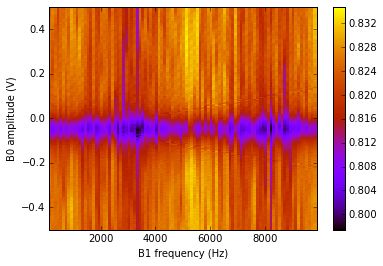

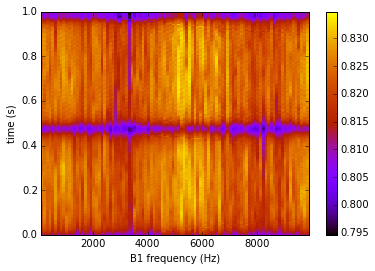

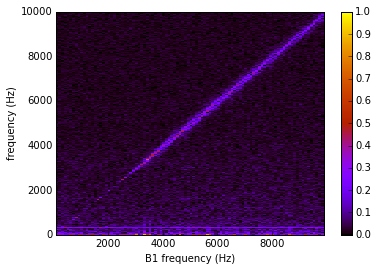

In [58]:
for i in range(len(files)):
    data = np.loadtxt(files[i], delimiter=',')
    if "-.csv" in files[i]:
        if cfg['outputs']['B0']['active'] is True and cfg['outputs']['B0']['func'].upper() in ['RAMP']:
            y_axis_label = cfg['outputs']['B0']['amp']['label']
            y_axis = np.linspace(-b0_amp/2, b0_amp/2,  
                                 num=len(data[sample_rate/downsampling_factor/4:sample_rate/downsampling_factor/4*3,:]))         
            X,Y = np.meshgrid(meas_ranges[0], y_axis)
            plt.pcolor(X,Y, data[sample_rate/downsampling_factor/4:sample_rate/downsampling_factor/4*3,:], cmap="gnuplot")
            plt.axis([X.min(), X.max(), Y.min(), Y.max()])
            plt.xlabel(x_axis_label)
            plt.ylabel(y_axis_label)
            plt.colorbar()
            plt.show()
            plt.savefig(filename+"/all_together{0:s}_raw.png".format(measno))
            plt.clf()
        elif cfg['outputs']['B1']['active'] is True and cfg['outputs']['B1']['freq_mod']['active'] is True:
            y_axis_label = cfg['outputs']['B1']['freq_mod']['span']['label']
            y_axis = np.linspace(b1_freq_center - b1_freq_span/2, b1_freq_center + b1_freq_span/2,  
                                 num=len(data[0:sample_rate/downsampling_factor/2,:]))
            X,Y = np.meshgrid(meas_ranges[0], y_axis)
            plt.pcolor(X,Y, data[0:sample_rate/downsampling_factor/2,:], cmap="gnuplot")
            plt.axis([X.min(), X.max(), Y.min(), Y.max()])
            plt.xlabel(x_axis_label)
            plt.ylabel(y_axis_label)
            plt.colorbar()
            plt.show()
            plt.savefig(filename+"/all_together{0:s}_raw.png".format(measno))
            plt.clf()
        else: 
            y_axis = np.linspace(0, measurement_time, num=sample_rate/downsampling_factor*measurement_time)
            y_axis_label = 'time (s)'
            X,Y = np.meshgrid(meas_ranges[0], y_axis)
            plt.pcolor(X,Y, data, cmap="gnuplot")
            plt.axis([X.min(), X.max(), Y.min(), Y.max()])
            plt.xlabel(x_axis_label)
            plt.ylabel(y_axis_label)
            plt.colorbar()
            plt.show()
            plt.savefig(filename+"/all_together{0:s}_raw.png".format(measno))
            plt.clf()

    if 'fft.csv' in files[i]:
        y_axis = np.linspace(0, sample_rate/downsampling_factor/2, num=len(data[:,0]))
        y_axis_label = 'frequency (Hz)'
        X,Y = np.meshgrid(meas_ranges[0], y_axis)
        # #z_min=data[110:].min()
        # #z_max=0.5
        # #plt.pcolor(X,Y, data, cmap="gnuplot", vmax=z_max, vmin=z_min)
        plt.pcolor(X,Y, data, cmap="gnuplot", vmax=1.0)
        plt.axis([X.min(), X.max(), Y.min(), Y.max()])
        plt.xlabel(x_axis_label)
        plt.ylabel(y_axis_label)
        plt.colorbar()
        plt.show()
        plt.savefig(filename+"/all_together{0:s}_fft.png".format(measno))
        plt.clf()


In [53]:
y_axis = np.linspace(-b0_amp/2, b0_amp/2,  
                                 num=len(data[sample_rate/downsampling_factor/4:sample_rate/downsampling_factor/4*3,:]))